Informations:
* Data collecting tool: **Atop**  
* Features extraction tool: **Atop**

In [31]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

folder = os.path.join("..", "0_dataset", "accounting")
filenames = ['label_atop_mirai.csv', 'label_atop_disk_wipe.csv', 'label_atop_ransomware.csv',
                  'label_atop_resource_hijacking.csv', 'label_atop_end_point_dos.csv']
filename_label = 'preprocess_label_atop.csv'
label_table_path = 'labels_table.json'

1. Preprocessing

In [32]:
one_hot_col_list = ['POLI', 'ST', 'EXC', 'S']
# removed_fields = ['TIMESTAMP', 'PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
removed_fields = ['PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
replace_strings = {'%': '', 'K': '000', 'M': '000000', 'G': '000000000'}
remove_rows_with_str = {'-': '0'}

df = pd.DataFrame()
for tmp_filename in filenames:
    print("\n")
    print("-------------------------------------\n")
    print("file name:{0}".format(tmp_filename))
    filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(filename)

    # simple analysis
    labels = tmp_df['Label'].unique()
    print('labels: {0}'.format(labels))
    
    df = df.append(tmp_df)

# delete useless features
df.drop(columns=removed_fields, axis=1, inplace=True)

# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_col_list)

df.drop_duplicates(keep=False, inplace=True)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# turn to number
for k in list(df):
    df[k] = pd.to_numeric(df[k], errors='ignore')

output_filename = os.path.join(folder, filename_label)
df.to_csv(output_filename, encoding='utf-8', index=False)



-------------------------------------

file name:label_atop_mirai.csv
labels: [ 0  1  2  3  5  9 11 12]


C:\Users\user\AppData\Local\Temp\ipykernel_4424\346503022.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)




-------------------------------------

file name:label_atop_disk_wipe.csv
labels: [ 0  1  2  4  6  8 14]


C:\Users\user\AppData\Local\Temp\ipykernel_4424\346503022.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)




-------------------------------------

file name:label_atop_ransomware.csv
labels: [ 0  1  4  6  7 12 15]


C:\Users\user\AppData\Local\Temp\ipykernel_4424\346503022.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)




-------------------------------------

file name:label_atop_resource_hijacking.csv
labels: [ 0  1  2  6  8 16]


C:\Users\user\AppData\Local\Temp\ipykernel_4424\346503022.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)




-------------------------------------

file name:label_atop_end_point_dos.csv
labels: [ 0 17  2]


C:\Users\user\AppData\Local\Temp\ipykernel_4424\346503022.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)


2. training preparation

In [41]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

df = pd.read_csv(os.path.join(folder, filename_label))
del_list = ['TIMESTAMP']


print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# data cleaning
df.drop_duplicates(keep=False, inplace=True)
df.drop(columns=del_list, inplace=True)


# data cleaning for normal data
df_tmp = df.loc[df['Label'] == 0].copy()
df_tmp.drop_duplicates(keep=False, inplace=True)
# df_tmp = df_tmp.sample(n=50000, random_state=47)
df.drop(df[df['Label'] == 0].index, inplace=True)
df = pd.concat([df, df_tmp])


# # feature scaling
# y_tmp = df['Label']
# df.drop(columns=['Label'], inplace=True)
# for feature in df.columns.values:
#     # scaler = RobustScaler().fit(df[feature].values.reshape(-1, 1))
#     scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
#     # scaler = Normalizer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = QuantileTransformer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = PowerTransformer().fit(df[feature].values.reshape(-1, 1))
#     df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
# df = pd.concat([df, y_tmp], axis=1)


# feature selection
y_tmp = df['Label']
y = df['Label'].values.astype(int)
df.drop('Label', axis=1, inplace=True)
selector = VarianceThreshold(threshold=0)
selector.fit(df)
print(selector.variances_)
constant_columns = [column for column in df.columns
                    if column not in 
                    df.columns[selector.get_support()]]
df.drop(labels=constant_columns, axis=1, inplace=True)

df_tmp = df
corr_features = set()
corr_matrix = df_tmp.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
df.drop(labels=corr_features, axis=1, inplace=True)

df = pd.concat([df, y_tmp], axis=1)


# copy data
for class_label in df['Label'].unique():
    while len(df[df['Label'] == class_label]) < 50:
        tmp_df = df[df['Label'] == class_label]
        df = pd.concat([df, tmp_df])


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, "select_"+filename_label)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 7758541
origin features: 50
[8.70000000e+07 9.78400000e+07 8.19720000e+07 1.00000000e+02
 1.66800000e+07 5.08706196e-01 4.58110000e+07 9.35560000e+07
 9.79760000e+07 9.97000000e+07 1.00712000e+08 3.19599052e+00
 1.71330231e-01 4.17291950e+01 2.04621285e-04 2.94639217e+01
 1.39000000e+02 2.31444966e-01 2.25835437e-01 1.86804809e+01
 5.49754018e-02 0.00000000e+00 5.49962587e-02 2.36144237e-05
 1.81833456e-01 2.55404451e-02 7.08399250e-05 1.47938063e-01
 3.08565063e-02 2.12489661e-04 5.49754018e-02 4.02461233e-02
 1.22902148e-02 3.14856504e-05 7.87159849e-06 7.87104082e-05
 3.93567532e-05 3.14856504e-05 5.50985869e-05 2.36094047e-04
 3.37335703e-03 3.14856504e-05 3.14856504e-05 1.41669812e-04
 5.49754018e-02 6.29693179e-05 1.49441349e-01 1.83994552e-01
 1.60324008e-03]
remain data number: 127108
remain features: 41


3. Visualization (data number)


Data number:
class0: 97549
class1: 91
class2: 550
class3: 478
class4: 171
class5: 720
class6: 2065
class7: 3973
class8: 8314
class9: 80
class11: 1322
class12: 3554
class14: 1980
class15: 1626
class16: 2285
class17: 2350


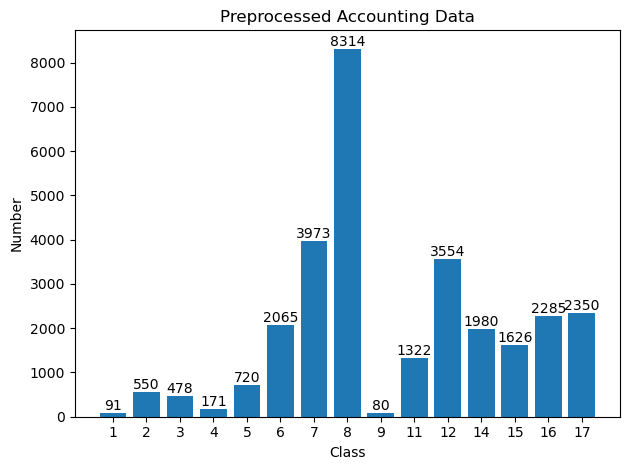

In [42]:
def bar_class_num(technique_data_size):
    class_num = np.arange(len(technique_data_size))
    # data_nums = plt.bar(class_num, technique_data_size, 0.2)
    data_nums = plt.bar(class_num, technique_data_size)
    for item in data_nums:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
        )
    labels.pop(0)
    plt.xticks(class_num, labels)
    plt.xlabel("Class")
    plt.ylabel("Number")
    plt.title("Preprocessed Accounting Data")
    plt.tight_layout()
    plt.savefig("accounting.png", dpi=400)
    plt.show()

technique_data_size = []
df = pd.read_csv(os.path.join(folder, "select_"+filename_label))
labels = df['Label'].unique()
labels = [int(i) for i in labels]
labels.sort()
with open("labels_table.json", "r") as f:
    label_table = json.load(f)

for i in labels:
    if i != 0:
        class_data_size = len(df[df['Label'] == i])
        technique_data_size.append(class_data_size)

print("\nData number:")
for i in labels:
    print("class{0}: {1}".format(i, len(df[df['Label'] == i])))

bar_class_num(technique_data_size)